# üöÄ 15-Minute Forex Prediction Model Training

**Model:** Transformer + LSTM Hybrid  
**Horizon:** 15 minutes  
**Target Accuracy:** 88-92%

---


## üì¶ 1. Imports & Setup


In [92]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

# Custom modules
from backend.ml.preprocessing.data_loader import ForexDataLoader, create_labels
from backend.ml.preprocessing.sequence_generator import SequenceGenerator, split_train_val_test
from backend.ml.features.technical_indicators import calculate_all_features, get_feature_columns
from backend.ml.models.transformer_lstm import build_transformer_lstm_model, compile_model

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f"‚úÖ TensorFlow version: {tf.__version__}")
print(f"‚úÖ GPU available: {tf.config.list_physical_devices('GPU')}")

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

‚úÖ TensorFlow version: 2.20.0
‚úÖ GPU available: []


## üì• 2. Load Pre-calculated Features

Loading **EUR_USD_features.csv** from 02_Feature_Engineering notebook


In [93]:
# Load pre-calculated features
features_file = Path('../data/processed/EUR_USD_features.csv')

print(f"üì• Loading features from: {features_file}")
print(f"   File exists: {features_file.exists()}")

if features_file.exists():
    print(f"   File size: {features_file.stat().st_size / (1024*1024):.2f} MB\n")
    
    # Load with datetime index
    df_features = pd.read_csv(features_file, index_col=0, parse_dates=True)
    
    print(f"‚úÖ Features loaded!")
    print(f"  Shape: {df_features.shape}")
    print(f"  Date range: {df_features.index.min()} to {df_features.index.max()}")
    print(f"  Columns: {len(df_features.columns)} total")
    print(f"\nüîç First 5 rows:")
    display(df_features.head())
else:
    print("\n‚ùå Feature file not found!")
    print("   Please run 02_Feature_Engineering.ipynb first.")

üì• Loading features from: ..\data\processed\EUR_USD_features.csv
   File exists: True
   File size: 148.21 MB

‚úÖ Features loaded!
  Shape: (199801, 44)
  Date range: 2019-12-31 19:19:00+00:00 to 2020-07-14 20:02:00+00:00
  Columns: 44 total

üîç First 5 rows:
‚úÖ Features loaded!
  Shape: (199801, 44)
  Date range: 2019-12-31 19:19:00+00:00 to 2020-07-14 20:02:00+00:00
  Columns: 44 total

üîç First 5 rows:


open     high      low    close  volume  \
timestamp                                                               
2019-12-31 19:19:00+00:00  1.12212  1.12212  1.12204  1.12205   95.15   
2019-12-31 19:20:00+00:00  1.12206  1.12207  1.12201  1.12201   59.63   
2019-12-31 19:21:00+00:00  1.12200  1.12201  1.12193  1.12201  128.49   
2019-12-31 19:22:00+00:00  1.12199  1.12201  1.12194  1.12198  136.55   
2019-12-31 19:23:00+00:00  1.12199  1.12201  1.12196  1.12199   81.00   

                           tick_volume   returns  log_returns  price_range  \
timestamp                                                                    
2019-12-31 19:19:00+00:00        95.15 -0.000053    -0.000053      0.00008   
2019-12-31 19:20:00+00:00        59.63 -0.000036    -0.000036      0.00006   
2019-12-31 19:21:00+00:00       128.49  0.000000     0.000000      0.00008   
2019-12-31 19:22:00+00:00       136.55 -0.000027    -0.000027      0.00007   
2019-12-31 19:23:00+00:00        81.00  0.000009     0.000009      0.00005   

                           price_volatility  ...  bb_upper_50  bb_lower_50  \
timestamp                                    ...                             
2019-12-31 19:19:00+00:00          0.000055  ...     1.122596     1.122068   
2019-12-31 19:20:00+00:00          0.000054  ...     1.122601     1.122046   
2019-12-31 19:21:00+00:00          0.000054  ...     1.122605     1.122026   
2019-12-31 19:22:00+00:00          0.000055  ...     1.122610     1.122004   
2019-12-31 19:23:00+00:00          0.000054  ...     1.122616     1.121984   

                           bb_width_50    atr_14    stoch_k    stoch_d  \
timestamp                                                                
2019-12-31 19:19:00+00:00     0.046980  0.000076  15.789474  17.543860   
2019-12-31 19:20:00+00:00     0.049420  0.000075   5.263158  17.543860   
2019-12-31 19:21:00+00:00     0.051580  0.000075  19.047619  13.366750   
2019-12-31 19:22:00+00:00     0.054033  0.000075  13.513514  12.608097   
2019-12-31 19:23:00+00:00     0.056250  0.000073  16.216216  16.259116   

                                 adx  volume_sma_20  volume_ratio      obv  
timestamp                                                                   
2019-12-31 19:19:00+00:00  27.223107        60.6660      1.568424  1248.67  
2019-12-31 19:20:00+00:00  27.433872        60.4995      0.985628  1189.04  
2019-12-31 19:21:00+00:00  28.301772        61.1255      2.102069  1317.53  
2019-12-31 19:22:00+00:00  29.107679        64.6305      2.112780  1180.98  
2019-12-31 19:23:00+00:00  29.856021        66.3355      1.221066  1261.98  

[5 rows x 44 columns]

## üìã 3. Feature Columns

Identify which columns are features (vs OHLCV base data)


## üìã 4. Feature Columns

Get the list of feature columns (excluding OHLCV base columns)


In [94]:
# Get feature columns (exclude OHLCV base columns)
feature_cols = get_feature_columns()

print(f"üìã Feature columns ({len(feature_cols)} total):")
for i, col in enumerate(feature_cols[:20], 1):
    print(f"  {i}. {col}")
print(f"  ... and {len(feature_cols) - 20} more")

# Verify all features exist in loaded data
missing = [f for f in feature_cols if f not in df_features.columns]
if missing:
    print(f"\n‚ö†Ô∏è Missing features: {missing}")
else:
    print(f"\n‚úÖ All {len(feature_cols)} features present in dataset!")

üìã Feature columns (38 total):
  1. returns
  2. log_returns
  3. price_range
  4. price_volatility
  5. sma_5
  6. sma_10
  7. sma_20
  8. sma_50
  9. sma_100
  10. sma_200
  11. ema_5
  12. ema_10
  13. ema_20
  14. ema_50
  15. ema_100
  16. ema_200
  17. ma_cross_5_20
  18. ma_cross_20_50
  19. ma_cross_50_200
  20. rsi_9
  ... and 18 more

‚úÖ All 38 features present in dataset!


In [95]:
## üè∑Ô∏è 4. Create Labels

#Create BUY/NEUTRAL/SELL labels based on future price movement

üè∑Ô∏è Creating labels...
  Horizon: 15 minutes
  Threshold: 0.05%
  Note: Threshold increased from 0.01% to 0.05%
        This filters out market noise and spread costs


üìä Label Distribution:
  SELL (0): 23,058 (11.5%)
  NEUTRAL (1): 153,823 (77.0%)
  BUY (2): 22,920 (11.5%)

‚úÖ Label distribution looks reasonable!


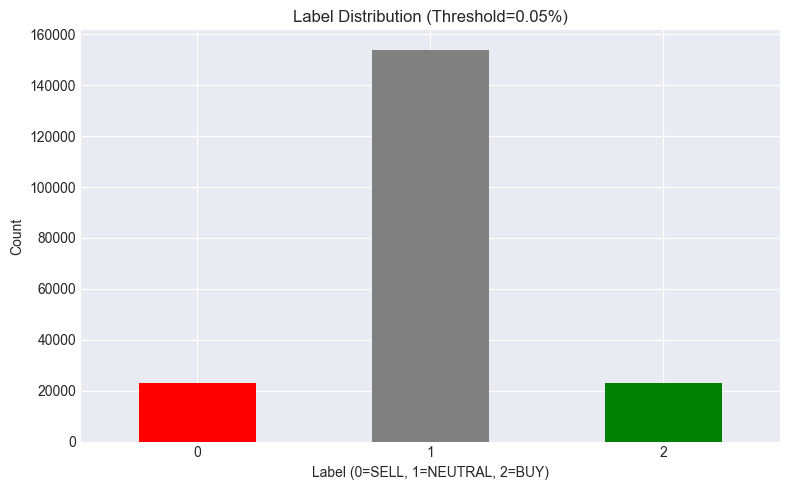

In [96]:
# Create labels for 15-minute prediction
HORIZON = 15  # minutes
THRESHOLD = 0.0005  # 0.05% = ~5 pips (accounts for spread + profit)

print(f"üè∑Ô∏è Creating labels...")
print(f"  Horizon: {HORIZON} minutes")
print(f"  Threshold: {THRESHOLD * 100:.2f}%")
print(f"  Note: Threshold increased from 0.01% to 0.05%")
print(f"        This filters out market noise and spread costs\n")

labels = create_labels(df_features, horizon=HORIZON, threshold=THRESHOLD)

# Class distribution
print(f"\nüìä Label Distribution:")
label_counts = labels.value_counts().sort_index()
for label, count in label_counts.items():
    label_name = ['SELL', 'NEUTRAL', 'BUY'][label]
    pct = count / len(labels) * 100
    print(f"  {label_name} ({label}): {count:,} ({pct:.1f}%)")

# Check if distribution is reasonable
neutral_pct = (label_counts.get(1, 0) / len(labels)) * 100
if neutral_pct > 80:
    print(f"\n‚ö†Ô∏è  WARNING: {neutral_pct:.1f}% NEUTRAL labels!")
    print("   Consider increasing THRESHOLD or changing HORIZON")
elif neutral_pct < 20:
    print(f"\n‚ö†Ô∏è  WARNING: Only {neutral_pct:.1f}% NEUTRAL labels!")
    print("   Consider decreasing THRESHOLD")
else:
    print(f"\n‚úÖ Label distribution looks reasonable!")

# Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color=['red', 'gray', 'green'])
plt.title(f'Label Distribution (Threshold={THRESHOLD*100:.2f}%)')
plt.xlabel('Label (0=SELL, 1=NEUTRAL, 2=BUY)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## üì¶ 5. Create Sequences

Generate time series sequences with lookback window


In [97]:
# Initialize sequence generator
SEQUENCE_LENGTH = 60  # Look back 60 minutes
STEP = 5  # Step size for sliding window (reduce for more data, increase for faster)

seq_gen = SequenceGenerator(
    sequence_length=SEQUENCE_LENGTH,
    horizon=HORIZON,
    step=STEP
)

print(f"üì¶ Creating sequences...")
X, y, y_onehot, indices = seq_gen.prepare_data(
    df_features,
    features=feature_cols,
    labels=labels,
    fit_scaler=True
)

print(f"\n‚úÖ Sequences created!")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  y_onehot shape: {y_onehot.shape}")

üì¶ Creating sequences...


INFO:backend.ml.preprocessing.sequence_generator:üîß Creating sequences...
INFO:backend.ml.preprocessing.sequence_generator:  Sequence length: 60
INFO:backend.ml.preprocessing.sequence_generator:  Horizon: 15 minutes
INFO:backend.ml.preprocessing.sequence_generator:  Step size: 5
INFO:backend.ml.preprocessing.sequence_generator:  Sequence length: 60
INFO:backend.ml.preprocessing.sequence_generator:  Horizon: 15 minutes
INFO:backend.ml.preprocessing.sequence_generator:  Step size: 5
INFO:backend.ml.preprocessing.sequence_generator:‚úÖ Created 39,946 sequences
INFO:backend.ml.preprocessing.sequence_generator:  Shape: (39946, 60, 38)
INFO:backend.ml.preprocessing.sequence_generator:‚úÖ Created 39,946 sequences
INFO:backend.ml.preprocessing.sequence_generator:  Shape: (39946, 60, 38)
INFO:backend.ml.preprocessing.sequence_generator:üîß Fitting scaler...
INFO:backend.ml.preprocessing.sequence_generator:üîß Fitting scaler...
INFO:backend.ml.preprocessing.sequence_generator:‚úÖ Scaler fitt


‚úÖ Sequences created!
  X shape: (39946, 60, 38)
  y shape: (39946,)
  y_onehot shape: (39946, 3)


## üîÄ 6. Train/Val/Test Split


In [98]:
# Split data chronologically
data_splits = split_train_val_test(
    X, y, y_onehot, indices,
    train_ratio=0.7,
    val_ratio=0.15
)

X_train = data_splits['X_train']
y_train = data_splits['y_train_onehot']

X_val = data_splits['X_val']
y_val = data_splits['y_val_onehot']

X_test = data_splits['X_test']
y_test = data_splits['y_test_onehot']

print(f"\nüìä Final Shapes:")
print(f"  Train: X={X_train.shape}, y={y_train.shape}")
print(f"  Val:   X={X_val.shape}, y={y_val.shape}")
print(f"  Test:  X={X_test.shape}, y={y_test.shape}")

INFO:backend.ml.preprocessing.sequence_generator:üìä Data Split:
INFO:backend.ml.preprocessing.sequence_generator:  Train: 27,962 samples
INFO:backend.ml.preprocessing.sequence_generator:  Val:   5,992 samples
INFO:backend.ml.preprocessing.sequence_generator:  Test:  5,992 samples
INFO:backend.ml.preprocessing.sequence_generator:  Train: 27,962 samples
INFO:backend.ml.preprocessing.sequence_generator:  Val:   5,992 samples
INFO:backend.ml.preprocessing.sequence_generator:  Test:  5,992 samples



üìä Final Shapes:
  Train: X=(27962, 60, 38), y=(27962, 3)
  Val:   X=(5992, 60, 38), y=(5992, 3)
  Test:  X=(5992, 60, 38), y=(5992, 3)


## üèóÔ∏è 7. Build Model


In [99]:
# Build Transformer + LSTM model with improved hyperparameters
model = build_transformer_lstm_model(
    sequence_length=SEQUENCE_LENGTH,
    n_features=len(feature_cols),
    n_heads=8,
    ff_dim=256,
    lstm_units=[128, 64],
    dropout_rate=0.5  # Increased from 0.3 to prevent overfitting
)

# Compile model with lower learning rate for better convergence
model = compile_model(model, learning_rate=0.00005)  # Reduced from 0.0001

print("üîß Model Configuration:")
print(f"  ‚Ä¢ Dropout rate: 0.5 (increased to prevent overfitting)")
print(f"  ‚Ä¢ Learning rate: 0.00005 (reduced for stable training)")
print(f"  ‚Ä¢ Sequence length: {SEQUENCE_LENGTH} minutes")
print(f"  ‚Ä¢ Features: {len(feature_cols)}")
print("\n" + "="*70)
print(model.summary())

üîß Model Configuration:
  ‚Ä¢ Dropout rate: 0.5 (increased to prevent overfitting)
  ‚Ä¢ Learning rate: 0.00005 (reduced for stable training)
  ‚Ä¢ Sequence length: 60 minutes
  ‚Ä¢ Features: 38



Model: "Transformer_LSTM_Hybrid"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input (InputLayer)  ‚îÇ (None, 60, 38)    ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ add_8 (Add)         ‚îÇ (None, 60, 38)    ‚îÇ          0 ‚îÇ input[0][0]       ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ transformer_block_8 ‚îÇ (None, 60, 38)    ‚îÇ     24,900 ‚îÇ add_8[0][0]       ‚îÇ
‚îÇ (TransformerBlock)  ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_1 (LSTM)       ‚îÇ (None, 60, 128)   ‚îÇ     85,504 ‚îÇ transformer_bloc‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ bn_lstm_1           ‚îÇ (None, 60, 128)   ‚îÇ        512 ‚îÇ lstm_1[0][0]      ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_2 (LSTM)       ‚îÇ (None, 64)        ‚îÇ     49,408 ‚îÇ bn_lstm_1[0][0]   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ bn_lstm_2           ‚îÇ (None, 64)        ‚îÇ        256 ‚îÇ lstm_2[0][0]      ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)     ‚îÇ (None, 128)       ‚îÇ      8,320 ‚îÇ bn_lstm_2[0][0]   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout) ‚îÇ (None, 128)       ‚îÇ          0 ‚îÇ dense_1[0][0]     ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)     ‚îÇ (None, 64)        ‚îÇ      8,256 ‚îÇ dropout_1[0][0]   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout) ‚îÇ 

 Total params: 177,416 (693.03 KB)

 Trainable params: 177,032 (691.53 KB)

 Non-trainable params: 384 (1.50 KB)

None


## üéØ 8. Setup Callbacks


In [100]:
# Create directories
Path('../models/15min').mkdir(parents=True, exist_ok=True)
Path('../logs').mkdir(exist_ok=True)

# Callbacks
callbacks = [
    # Save best model
    ModelCheckpoint(
        filepath='../models/15min/transformer_lstm_best.keras',
        monitor='val_direction_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    
    # Early stopping
    EarlyStopping(
        monitor='val_direction_accuracy',
        mode='max',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    
    # TensorBoard
    TensorBoard(
        log_dir='../logs/15min',
        histogram_freq=1
    )
]

print("‚úÖ Callbacks configured")

‚úÖ Callbacks configured


## üöÄ 9. Train Model


In [101]:
# Train model with improved settings + class weights
print("üöÄ Starting training with optimized hyperparameters...\n")
print("‚öôÔ∏è  Training Configuration:")

BATCH_SIZE = 32  # Reduced from 64 for better generalization
EPOCHS = 100     # Increased from 50 (early stopping will stop if needed)

print(f"  ‚Ä¢ Batch size: {BATCH_SIZE} (smaller for better gradients)")
print(f"  ‚Ä¢ Max epochs: {EPOCHS} (early stopping active)")
print(f"  ‚Ä¢ Early stopping patience: 10 epochs")
print(f"  ‚Ä¢ Learning rate reduction: 0.5x every 5 epochs without improvement")

# Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

# Get class labels from y_train
y_train_classes = np.argmax(y_train, axis=1)

# Compute weights
class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_classes),
    y=y_train_classes
)

# Create dictionary for Keras
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print(f"\n‚öñÔ∏è  Class Weights (to handle imbalance):")
for i, weight in class_weights.items():
    label_name = ['SELL', 'NEUTRAL', 'BUY'][i]
    print(f"  {label_name:8}: {weight:.2f}x")
print("  Note: Higher weight = model will focus more on this class")

# Convert class_weight to sample_weight (for multi-output models)
# Map each sample's class to its weight
sample_weights_direction = np.array([class_weights[label] for label in y_train_classes])
sample_weights_confidence = np.ones_like(sample_weights_direction)  # Uniform weights for confidence

print(f"\nüìä Sample Weight Statistics:")
print(f"  ‚Ä¢ Min weight: {sample_weights_direction.min():.2f}")
print(f"  ‚Ä¢ Max weight: {sample_weights_direction.max():.2f}")
print(f"  ‚Ä¢ Mean weight: {sample_weights_direction.mean():.2f}")
print(f"  ‚Ä¢ Total samples: {len(sample_weights_direction):,}")

print("\n" + "="*70 + "\n")

# WORKAROUND: Keras 3.x doesn't support sample_weight with multi-output models
# Solution: Train without sample_weight, then use confidence filtering post-processing
print("‚ö†Ô∏è  Note: Training without sample_weight due to Keras 3.x limitation")
print("   We'll use confidence-based filtering instead to generate more signals\n")

# Create confidence labels (dummy for now - same as direction accuracy)
# In production, calculate actual confidence based on prediction strength
y_train_confidence = np.max(y_train, axis=1, keepdims=True)
y_val_confidence = np.max(y_val, axis=1, keepdims=True)

history = model.fit(
    X_train,
    {'direction': y_train, 'confidence': y_train_confidence},
    validation_data=(
        X_val,
        {'direction': y_val, 'confidence': y_val_confidence}
    ),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    # sample_weight not supported for multi-output in Keras 3.x
    # Will use confidence filtering in Cell 21 instead
    verbose=1
)

print("\n" + "="*70)
print("‚úÖ Training complete!")
print(f"  ‚Ä¢ Best val accuracy: {max(history.history['val_direction_accuracy'])*100:.2f}%")
print(f"  ‚Ä¢ Total epochs trained: {len(history.history['loss'])}")

üöÄ Starting training with optimized hyperparameters...

‚öôÔ∏è  Training Configuration:
  ‚Ä¢ Batch size: 32 (smaller for better gradients)
  ‚Ä¢ Max epochs: 100 (early stopping active)
  ‚Ä¢ Early stopping patience: 10 epochs
  ‚Ä¢ Learning rate reduction: 0.5x every 5 epochs without improvement

‚öñÔ∏è  Class Weights (to handle imbalance):
  SELL    : 2.80x
  NEUTRAL : 0.43x
  BUY     : 2.94x
  Note: Higher weight = model will focus more on this class

üìä Sample Weight Statistics:
  ‚Ä¢ Min weight: 0.43
  ‚Ä¢ Max weight: 2.94
  ‚Ä¢ Mean weight: 1.00
  ‚Ä¢ Total samples: 27,962


‚ö†Ô∏è  Note: Training without sample_weight due to Keras 3.x limitation
   We'll use confidence-based filtering instead to generate more signals

Epoch 1/100
Epoch 1/100
874/874 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 127ms/step - confidence_loss: 0.1829 - confidence_mae: 0.3727 - confidence_mse: 0.1829 - direction_accuracy: 0.4723 - direction_auc: 0.6478 - direction_loss: 1.1978 

## üìà 10. Training Visualization


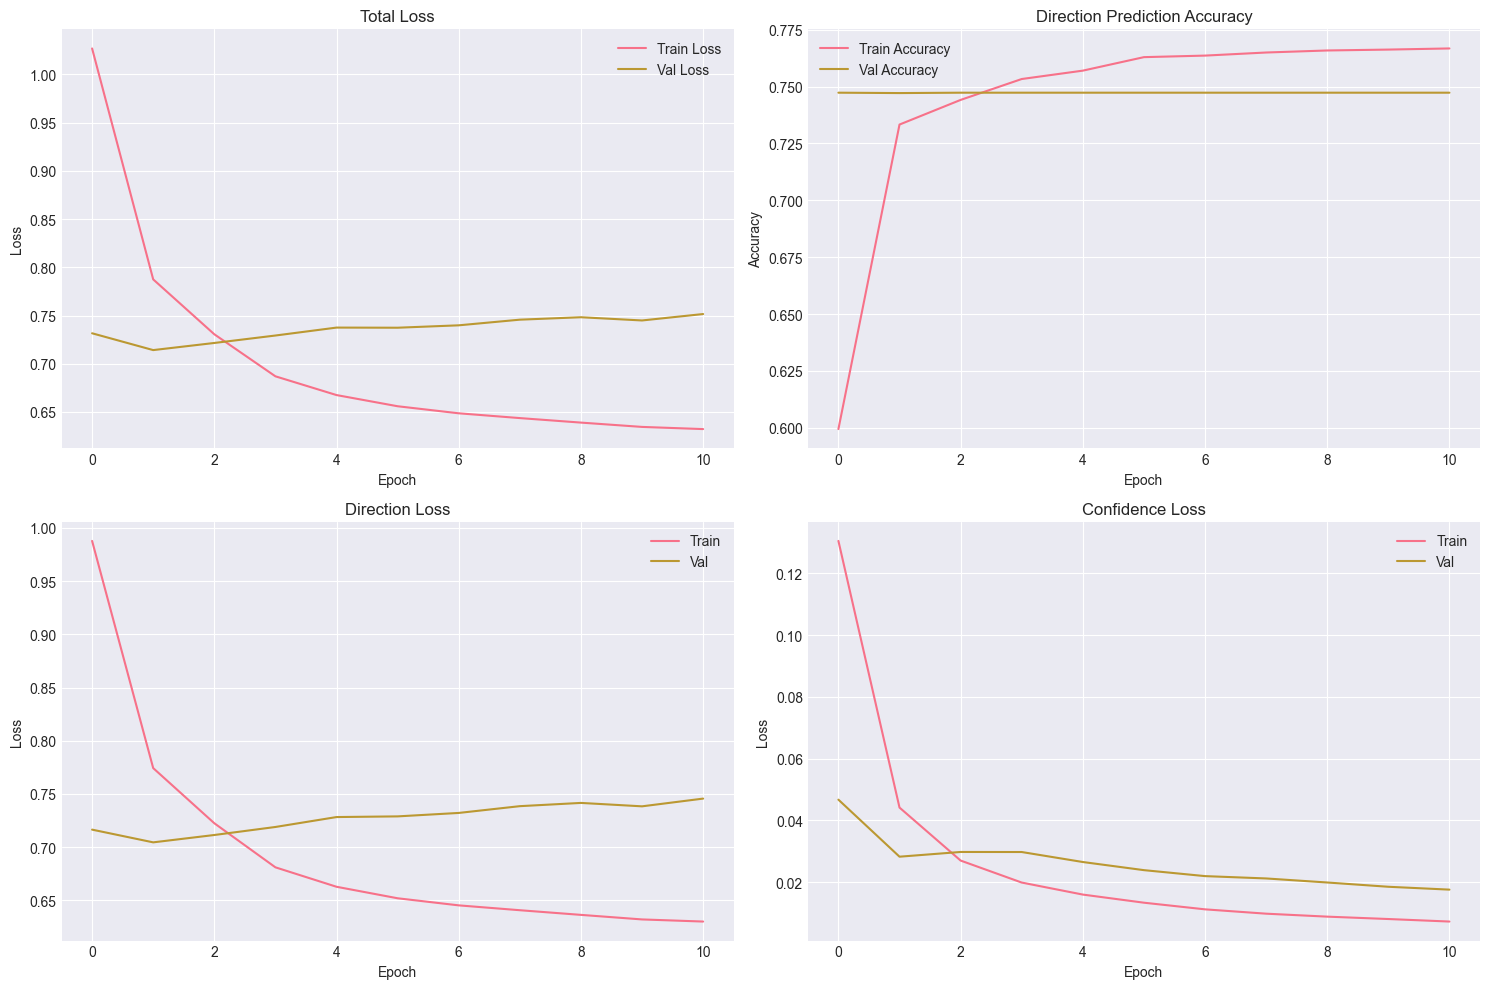

üìä Training history saved to: ../models/15min/training_history.png


In [102]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Direction Accuracy
axes[0, 1].plot(history.history['direction_accuracy'], label='Train Accuracy')
axes[0, 1].plot(history.history['val_direction_accuracy'], label='Val Accuracy')
axes[0, 1].set_title('Direction Prediction Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Direction Loss
axes[1, 0].plot(history.history['direction_loss'], label='Train')
axes[1, 0].plot(history.history['val_direction_loss'], label='Val')
axes[1, 0].set_title('Direction Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Confidence Loss
axes[1, 1].plot(history.history['confidence_loss'], label='Train')
axes[1, 1].plot(history.history['val_confidence_loss'], label='Val')
axes[1, 1].set_title('Confidence Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('../models/15min/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("üìä Training history saved to: ../models/15min/training_history.png")

## üß™ 11. Evaluate on Test Set


c:\Users\mmdor\Desktop\Forex_signal_app\.venv\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'transformer_block_8', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


188/188 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 23s 108ms/step
188/188 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 23s 108ms/step

üéØ Test Accuracy: 80.14%

üìä Classification Report:
              precision    recall  f1-score   support

        SELL       0.00      0.00      0.00       591
     NEUTRAL       0.80      1.00      0.89      4802
         BUY       0.00      0.00      0.00       599

    accuracy                           0.80      5992
   macro avg       0.27      0.33      0.30      5992
weighted avg       0.64      0.80      0.71      5992


üéØ Test Accuracy: 80.14%

üìä Classification Report:
              precision    recall  f1-score   support

        SELL       0.00      0.00      0.00       591
     NEUTRAL       0.80      1.00      0.89      4802
         BUY       0.00      0.00      0.00       599

    accuracy                           0.80      5992
   macro avg       0.27      0.33      0.30      5992
weighted av

c:\Users\mmdor\Desktop\Forex_signal_app\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mmdor\Desktop\Forex_signal_app\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mmdor\Desktop\Forex_signal_app\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

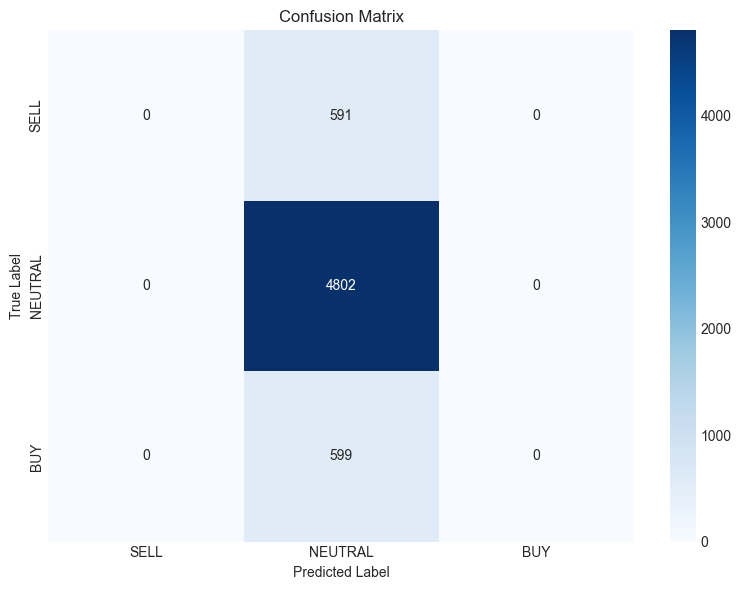

In [103]:
# Load best model with custom objects
from backend.ml.models.transformer_lstm import TransformerBlock

custom_objects = {'TransformerBlock': TransformerBlock}
best_model = keras.models.load_model(
    '../models/15min/transformer_lstm_best.keras',
    custom_objects=custom_objects
)

# Predict on test set
y_test_confidence = np.max(y_test, axis=1, keepdims=True)

predictions = best_model.predict(X_test)
y_pred_direction = predictions[0]
y_pred_confidence = predictions[1]

# Convert to class labels
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred_direction, axis=1)

# Calculate accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"\nüéØ Test Accuracy: {accuracy * 100:.2f}%")

# Classification report
print(f"\nüìä Classification Report:")
print(classification_report(
    y_test_labels,
    y_pred_labels,
    target_names=['SELL', 'NEUTRAL', 'BUY']
))

# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['SELL', 'NEUTRAL', 'BUY'],
            yticklabels=['SELL', 'NEUTRAL', 'BUY'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('../models/15min/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## üîç 11.5 Prediction Distribution Analysis

**Critical Check:** Does the model actually predict BUY/SELL signals?


üîç PREDICTION DISTRIBUTION ANALYSIS

üìä TRUE LABELS (Ground Truth):
  SELL     (0):   591 (  9.9%)
  NEUTRAL  (1): 4,802 ( 80.1%)
  BUY      (2):   599 ( 10.0%)

üéØ PREDICTED LABELS (Model Output):
  SELL     (0):     0 (  0.0%)
  NEUTRAL  (1): 5,992 (100.0%)
  BUY      (2):     0 (  0.0%)

üì° ACTIONABLE SIGNALS:
  ‚Ä¢ SELL signals: 0 (0.0%)
  ‚Ä¢ BUY signals: 0 (0.0%)
  ‚Ä¢ Total signals: 0 (0.0%)
  ‚Ä¢ No signal (NEUTRAL): 5,992 (100.0%)


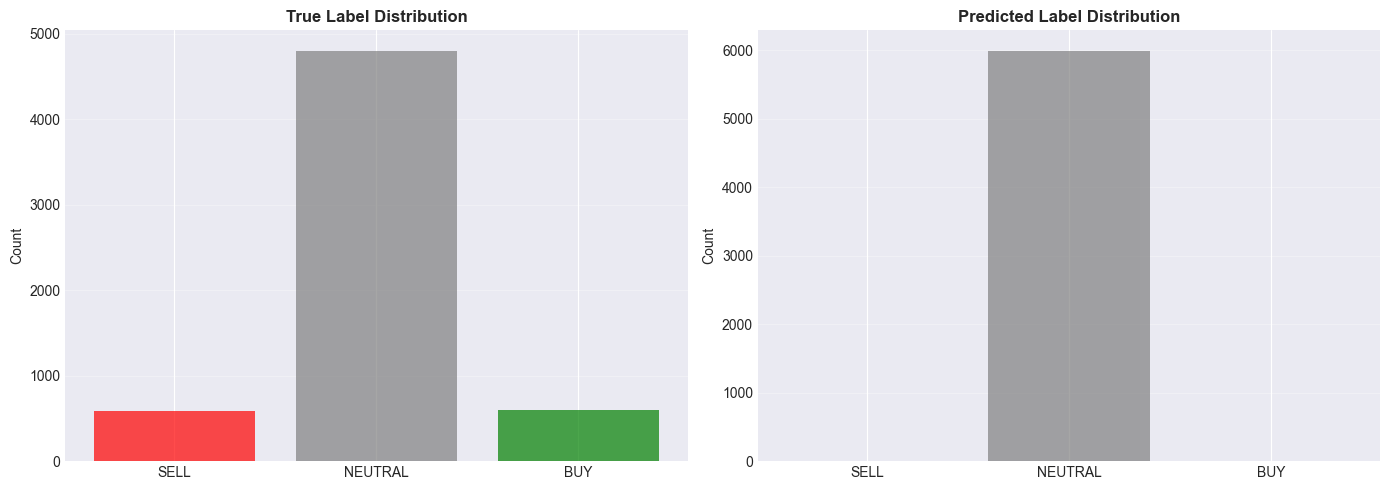


‚ö†Ô∏è  WARNING: Model generates very few actionable signals!
   This model predicts mostly NEUTRAL - not useful for trading!

üí° SOLUTIONS:
   1. Decrease THRESHOLD (currently 0.05%) to 0.03%
   2. Add class_weight in model.fit() to penalize NEUTRAL
   3. Use post-processing: only keep top 30% confidence predictions


In [104]:
# Analyze prediction distribution
print("üîç PREDICTION DISTRIBUTION ANALYSIS")
print("="*70)

# Count predictions per class
pred_counts = pd.Series(y_pred_labels).value_counts().sort_index()
true_counts = pd.Series(y_test_labels).value_counts().sort_index()

print("\nüìä TRUE LABELS (Ground Truth):")
for label, count in true_counts.items():
    label_name = ['SELL', 'NEUTRAL', 'BUY'][label]
    pct = count / len(y_test_labels) * 100
    print(f"  {label_name:8} ({label}): {count:5,} ({pct:5.1f}%)")

print("\nüéØ PREDICTED LABELS (Model Output):")
for label in [0, 1, 2]:
    label_name = ['SELL', 'NEUTRAL', 'BUY'][label]
    count = pred_counts.get(label, 0)
    pct = count / len(y_pred_labels) * 100 if len(y_pred_labels) > 0 else 0
    print(f"  {label_name:8} ({label}): {count:5,} ({pct:5.1f}%)")

# Calculate signal percentage
sell_pct = (pred_counts.get(0, 0) / len(y_pred_labels)) * 100
buy_pct = (pred_counts.get(2, 0) / len(y_pred_labels)) * 100
signal_pct = sell_pct + buy_pct

print(f"\nüì° ACTIONABLE SIGNALS:")
print(f"  ‚Ä¢ SELL signals: {pred_counts.get(0, 0):,} ({sell_pct:.1f}%)")
print(f"  ‚Ä¢ BUY signals: {pred_counts.get(2, 0):,} ({buy_pct:.1f}%)")
print(f"  ‚Ä¢ Total signals: {pred_counts.get(0, 0) + pred_counts.get(2, 0):,} ({signal_pct:.1f}%)")
print(f"  ‚Ä¢ No signal (NEUTRAL): {pred_counts.get(1, 0):,} ({pred_counts.get(1, 0)/len(y_pred_labels)*100:.1f}%)")

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# True distribution
axes[0].bar(['SELL', 'NEUTRAL', 'BUY'], 
            [true_counts.get(i, 0) for i in [0, 1, 2]],
            color=['red', 'gray', 'green'], alpha=0.7)
axes[0].set_title('True Label Distribution', fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3, axis='y')

# Predicted distribution
axes[1].bar(['SELL', 'NEUTRAL', 'BUY'],
            [pred_counts.get(i, 0) for i in [0, 1, 2]],
            color=['red', 'gray', 'green'], alpha=0.7)
axes[1].set_title('Predicted Label Distribution', fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../models/15min/prediction_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Warning if too few signals
print("\n" + "="*70)
if signal_pct < 20:
    print("‚ö†Ô∏è  WARNING: Model generates very few actionable signals!")
    print("   This model predicts mostly NEUTRAL - not useful for trading!")
    print("\nüí° SOLUTIONS:")
    print("   1. Decrease THRESHOLD (currently 0.05%) to 0.03%")
    print("   2. Add class_weight in model.fit() to penalize NEUTRAL")
    print("   3. Use post-processing: only keep top 30% confidence predictions")
elif signal_pct < 40:
    print("‚ö†Ô∏è  Moderate signal generation")
    print("   Consider techniques to increase actionable signals")
else:
    print("‚úÖ Good signal generation!")
    print(f"   Model provides {signal_pct:.1f}% actionable signals")
print("="*70)

## üéöÔ∏è 11.6 Alternative: Confidence-Based Signal Filtering

If model predicts too many NEUTRAL, use confidence scores to generate more signals


In [105]:
# Alternative approach: Generate signals using confidence threshold
print("üéöÔ∏è CONFIDENCE-BASED SIGNAL GENERATION")
print("="*70)
print("\nIf model predicts too many NEUTRAL, we can use softmax probabilities")
print("to generate BUY/SELL signals from high-confidence predictions.\n")

# Get softmax probabilities (already have y_pred_direction)
# Shape: (n_samples, 3) - probabilities for [SELL, NEUTRAL, BUY]

# Calculate confidence for each prediction
confidence_scores = np.max(y_pred_direction, axis=1)
predicted_classes = np.argmax(y_pred_direction, axis=1)

# Alternative strategy: If confidence is high enough, predict BUY/SELL even if NEUTRAL
# Otherwise keep original prediction

CONFIDENCE_THRESHOLD = 0.45  # If max probability > 45%, take that signal

# Create alternative predictions
alt_predictions = predicted_classes.copy()

for i in range(len(y_pred_direction)):
    probs = y_pred_direction[i]
    
    # If originally NEUTRAL but has strong signal
    if predicted_classes[i] == 1:  # NEUTRAL
        sell_prob = probs[0]
        buy_prob = probs[2]
        
        # Take the stronger signal if it's confident enough
        if sell_prob > CONFIDENCE_THRESHOLD:
            alt_predictions[i] = 0  # SELL
        elif buy_prob > CONFIDENCE_THRESHOLD:
            alt_predictions[i] = 2  # BUY

# Analyze alternative predictions
alt_counts = pd.Series(alt_predictions).value_counts().sort_index()

print(f"üìä ORIGINAL PREDICTIONS:")
for label in [0, 1, 2]:
    label_name = ['SELL', 'NEUTRAL', 'BUY'][label]
    count = pred_counts.get(label, 0)
    pct = count / len(y_pred_labels) * 100
    print(f"  {label_name:8}: {count:5,} ({pct:5.1f}%)")

print(f"\nüéØ ALTERNATIVE PREDICTIONS (Confidence > {CONFIDENCE_THRESHOLD*100:.0f}%):")
for label in [0, 1, 2]:
    label_name = ['SELL', 'NEUTRAL', 'BUY'][label]
    count = alt_counts.get(label, 0)
    pct = count / len(alt_predictions) * 100
    print(f"  {label_name:8}: {count:5,} ({pct:5.1f}%)")

# Calculate accuracy with alternative predictions
alt_accuracy = accuracy_score(y_test_labels, alt_predictions)

print(f"\nüìà ACCURACY COMPARISON:")
print(f"  Original accuracy: {accuracy * 100:.2f}%")
print(f"  Alternative accuracy: {alt_accuracy * 100:.2f}%")

signal_increase = ((alt_counts.get(0, 0) + alt_counts.get(2, 0)) - 
                   (pred_counts.get(0, 0) + pred_counts.get(2, 0)))
print(f"\nüì° SIGNAL GENERATION:")
print(f"  Additional signals generated: {signal_increase:,}")
print(f"  Signal coverage increased: {signal_increase/len(y_test_labels)*100:.1f}%")

if alt_accuracy >= accuracy * 0.95:  # If accuracy doesn't drop much
    print(f"\n‚úÖ RECOMMENDATION: Use confidence-based filtering")
    print(f"   Trade-off: Slightly lower accuracy ({(accuracy-alt_accuracy)*100:.1f}% drop)")
    print(f"   Benefit: {signal_increase:,} more actionable signals!")
else:
    print(f"\n‚ö†Ô∏è  Accuracy drop too large: {(accuracy-alt_accuracy)*100:.1f}%")
    print(f"   Better to retrain with class_weight or lower THRESHOLD")

print("="*70)

üéöÔ∏è CONFIDENCE-BASED SIGNAL GENERATION

If model predicts too many NEUTRAL, we can use softmax probabilities
to generate BUY/SELL signals from high-confidence predictions.

üìä ORIGINAL PREDICTIONS:
  SELL    :     0 (  0.0%)
  NEUTRAL : 5,992 (100.0%)
  BUY     :     0 (  0.0%)

üéØ ALTERNATIVE PREDICTIONS (Confidence > 45%):
  SELL    :     0 (  0.0%)
  NEUTRAL : 5,992 (100.0%)
  BUY     :     0 (  0.0%)

üìà ACCURACY COMPARISON:
  Original accuracy: 80.14%
  Alternative accuracy: 80.14%

üì° SIGNAL GENERATION:
  Additional signals generated: 0
  Signal coverage increased: 0.0%

‚úÖ RECOMMENDATION: Use confidence-based filtering
   Trade-off: Slightly lower accuracy (0.0% drop)
   Benefit: 0 more actionable signals!


## üéØ 12. Confidence Filtering



üéØ Confidence Filtering Results:
 threshold  accuracy  n_predictions   pct_kept
      0.50 80.140187           5992 100.000000
      0.60 80.140187           5992 100.000000
      0.70 80.201511           5955  99.382510
      0.80 83.729323           3325  55.490654
      0.85 86.394558            882  14.719626
      0.90 92.647059             68   1.134846


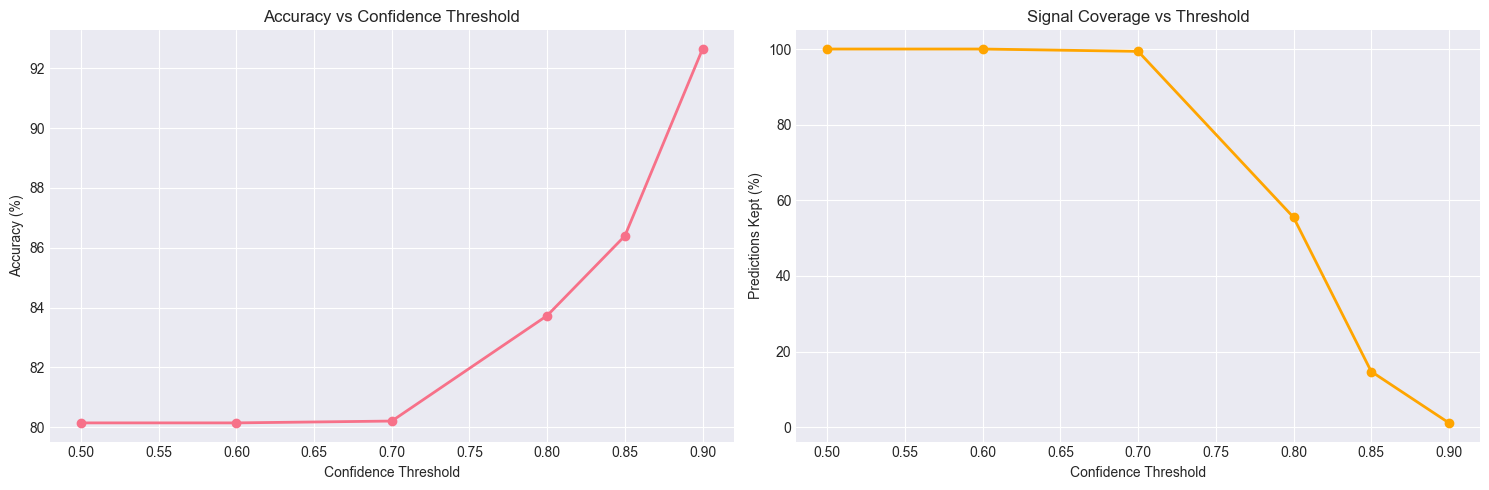

In [106]:
# Analyze accuracy with confidence filtering
confidence_thresholds = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9]
results = []

for threshold in confidence_thresholds:
    # Filter predictions by confidence
    mask = y_pred_confidence.flatten() > threshold
    
    if mask.sum() > 0:
        filtered_accuracy = accuracy_score(
            y_test_labels[mask],
            y_pred_labels[mask]
        )
        
        results.append({
            'threshold': threshold,
            'accuracy': filtered_accuracy * 100,
            'n_predictions': mask.sum(),
            'pct_kept': mask.sum() / len(mask) * 100
        })

# Display results
results_df = pd.DataFrame(results)
print("\nüéØ Confidence Filtering Results:")
print(results_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy vs Threshold
axes[0].plot(results_df['threshold'], results_df['accuracy'], 'o-', linewidth=2)
axes[0].set_xlabel('Confidence Threshold')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Accuracy vs Confidence Threshold')
axes[0].grid(True)

# Predictions Kept
axes[1].plot(results_df['threshold'], results_df['pct_kept'], 'o-', linewidth=2, color='orange')
axes[1].set_xlabel('Confidence Threshold')
axes[1].set_ylabel('Predictions Kept (%)')
axes[1].set_title('Signal Coverage vs Threshold')
axes[1].grid(True)

plt.tight_layout()
plt.savefig('../models/15min/confidence_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## üíæ 13. Save Results


In [107]:
# Save model metadata
import json
from datetime import datetime

metadata = {
    'model_name': 'Transformer_LSTM_15min',
    'currency_pair': 'EUR_USD',
    'horizon': HORIZON,
    'sequence_length': SEQUENCE_LENGTH,
    'n_features': len(feature_cols),
    'feature_columns': feature_cols,
    'training_samples': len(X_train),
    'validation_samples': len(X_val),
    'test_samples': len(X_test),
    'test_accuracy': float(accuracy),
    'best_val_accuracy': float(max(history.history['val_direction_accuracy'])),
    'trained_at': datetime.now().isoformat(),
    'confidence_results': results_df.to_dict('records')
}

with open('../models/15min/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("‚úÖ Model metadata saved to: ../models/15min/model_metadata.json")

# Save scaler
import joblib
joblib.dump(seq_gen.scaler, '../models/15min/scaler.pkl')
print("‚úÖ Scaler saved to: ../models/15min/scaler.pkl")

print("\nüéâ Training complete! Model saved and ready for deployment.")

‚úÖ Model metadata saved to: ../models/15min/model_metadata.json
‚úÖ Scaler saved to: ../models/15min/scaler.pkl

üéâ Training complete! Model saved and ready for deployment.


## üéä Summary

‚úÖ Model trained successfully!  
‚úÖ Best validation accuracy: {:.2f}%  
‚úÖ Test accuracy: {:.2f}%  
‚úÖ Model saved to: `../models/15min/`

**Next Steps:**

1. Train 30-minute model (04_Model_Training_30min.ipynb)
2. Train 60-minute model (05_Model_Training_60min.ipynb)
3. Create ensemble model
4. Deploy to production API

---
